In [1]:
%%time
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import glob
import os
from pathlib import Path
import time

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
states = ShapelyFeature(Reader('/glade/work/mazrooei/DATA/useful_shapefiles/states.shp').geometries(),
                                ccrs.PlateCarree(), facecolor='none', edgecolor='black')
proj = ccrs.Orthographic(central_longitude=-100, central_latitude=35)
ncproj = ccrs.PlateCarree()
# Define the projection of NWM
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
nwm_proj = ccrs.LambertConformal(globe=globe, central_longitude=-97.0, central_latitude=40.0, standard_parallels=(30.0,60.0))
extent_conus = [-122, -73, 22, 50]


CPU times: user 732 ms, sys: 254 ms, total: 986 ms
Wall time: 10 s


In [2]:
%%time
list_basins = pd.read_csv('/glade/work/mazrooei/USGS/usgs_ealstm/ealstm_regional_modeling/data/bkp.basin_list_all', dtype=str, names=['site_no']).site_no.to_list()
LSTM_valid = pd.read_pickle('/glade/work/mazrooei/USGS/usgs_ealstm/ealstm_regional_modeling/runs/run_seed588170_aorc_gagesII_trained_on_2008_2013/ealstm_eval_2000_2005.p')
LSTM_calib = pd.read_pickle('/glade/work/mazrooei/USGS/usgs_ealstm/ealstm_regional_modeling/runs/run_seed588170_aorc_gagesII_trained_on_2008_2013/ealstm_eval_2008_2013.p')

NHM_valid = dict() 
NHM_calib = dict() 
basins = list(LSTM_valid.keys())
# sorted(glob.glob("/glade/work/mazrooei/USGS/usgs_ealstm/NHMV1/NHMV1_daily_persite/*.txt"))
print("[INFO] Reading NHM flow simulations")
time.sleep(.5)
for b in tqdm(basins):
    f = "/glade/work/mazrooei/USGS/usgs_ealstm/NHMV1/NHMV1_daily_persite/"+b+".txt"
    d = pd.read_csv(f, sep=" ", header=0, names=["","qsim"], index_col=0)
    d.index = d.index.astype('<M8[ns]')
    
    o = LSTM_valid[b]['qobs']
    d2 = pd.concat([d, o], axis=1)
    d2['date'] = pd.to_datetime(d2.index)
    mask = (d2['date'] >= '2000-10-01') & (d2['date'] < '2005-10-01')
    d3 = d2.loc[mask][["qobs","qsim"]]
    NHM_valid[b] = d3
    
    o = LSTM_calib[b]['qobs']
    d2 = pd.concat([d, o], axis=1)
    d2['date'] = pd.to_datetime(d2.index)
    mask = (d2['date'] >= '2008-10-01') & (d2['date'] < '2013-10-01')
    d3 = d2.loc[mask][["qobs","qsim"]]
    NHM_calib[b] = d3


usgs_meta = pd.read_csv("/glade/p/cisl/nwc/nwm_verification_obs/streamflow_usgs/obsStrMeta.csv", dtype={'site_no': str}, index_col=0).set_index('site_no')
usgs_meta = usgs_meta.sort_index()
usgs_short_columns = ['station_nm', 'dec_lat_va', 'dec_long_va']
usgs_short = usgs_meta[usgs_short_columns]


[INFO] Reading NHM flow simulations


100%|██████████| 1291/1291 [01:22<00:00, 15.65it/s]


CPU times: user 58.2 s, sys: 1.86 s, total: 1min
Wall time: 1min 24s


In [14]:
def my_verif(obs, sim):
    # sim = df.qsim
    # obs = df.qobs
    if sim.notnull().sum() > 10:
        obs_mean = np.mean(obs)
        epsilon = 0.0001 * obs_mean
        obs_std = np.std(obs)
        obs_log = np.log(obs+epsilon)
        
        sim_mean = np.mean(sim)
        sim_std = np.std(sim)
        sim_log = np.log(sim+epsilon)

        Bias = sim_mean - obs_mean
        Err = sim-obs
        MSE = np.mean(Err**2)
        RMSE = np.sqrt(MSE)
        RRMSE = RMSE / obs_mean

        corr_pear = obs.corr(sim) 
        corr_rank = obs.corr(sim, method='spearman')

        if obs_std == 0:
            KGE_alpha = np.nan
            NSE_C = np.nan
        else:
            KGE_alpha = sim_std  / obs_std
            NSE_C = (Bias / obs_std)**2

        if obs_mean == 0:
            PBias = np.nan
            KGE_beta = np.nan
        else:
            PBias = 100*Bias / obs_mean
            KGE_beta  = sim_mean / obs_mean

        NSE_A = corr_pear**2
        NSE_B = (corr_pear - KGE_alpha)**2


        NSE = 1-( np.sum(Err**2) / np.sum((obs-obs_mean)**2) )
        KGE = 1-( np.sqrt( (corr_pear-1)**2 + (KGE_alpha-1)**2 + (KGE_beta-1)**2 ) )
        LogNSE = 1-( np.sum((sim_log-obs_log)**2) / np.sum((obs_log-np.mean(obs_log))**2))
        WtNSE = (0.5*NSE) + (0.5*LogNSE)

        # YILMAZ ET AL 2008
        n  = len(obs)
        
        m1 = .2
        m2 = .7
        sim_MS = sorted(sim, reverse=True)[round(n*m1):round(n*m2)]
        obs_MS = sorted(obs, reverse=True)[round(n*m1):round(n*m2)]
        QOm1 = obs_MS[0]
        QOm2 = obs_MS[-1]
        QSm1 = sim_MS[0]
        QSm2 = sim_MS[-1]
        #FDC midsegment slope bias
        PBias_FMS = 100*(((np.log(QSm1)-np.log(QSm2))-(np.log(QOm1)-np.log(QOm2)))/(np.log(QOm1)-np.log(QOm2))) 

        
        
        qH = 0.02 # high flow quantile
        sim_FH = sorted(sim, reverse=True)[:round(n*qH)]
        obs_FH = sorted(obs, reverse=True)[:round(n*qH)]
        #FDC high volume bias, top %2 flows
        PBias_FHV = 100*np.sum(np.subtract(sim_FH,obs_FH))/np.sum(obs_FH) 
        
        qL = 0.7 # Low flow quantile
        sim_FL = sorted(sim, reverse=True)[round(n*qL):]
        obs_FL = sorted(obs, reverse=True)[round(n*qL):]
        if (sim_FL[-1]==0 or obs_FL[-1]==0):
            epsilon2 = 0.0001 * np.min([np.mean(sim_FL), np.mean(obs_FL)])
            sim_FL = np.add(sim_FL, epsilon2)
            obs_FL = np.add(obs_FL, epsilon2)
#         ## FDC low volume bias, Low 30% flows YILMAZ ET AL 2008
#         S1 = np.sum(np.subtract(np.log(sim_FL),np.log(sim_FL[0])))
#         S2 = np.sum(np.subtract(np.log(obs_FL),np.log(obs_FL[0])))
#         PBias_FLV = -100 * (S1-S2)/(S2)
        min_FL = np.min([sim_FL, obs_FL]) ## Pokhrel et al 2008
        S1 = np.sum(np.subtract(np.log(sim_FL),np.log(min_FL)))
        S2 = np.sum(np.subtract(np.log(obs_FL),np.log(min_FL)))
        PBias_FLV = 100 * (S1-S2)/(S2)            
            
        out_df = pd.DataFrame({'mean_obs':obs_mean,
                               'mean_sim':sim_mean, 
                               'std_obs':obs_std,
                               'std_sim':sim_std, 
                               'Bias': Bias,
                               'PBias': PBias,
#                                'PBias_FMS': PBias_FMS,
                               'PBias_FLV': PBias_FLV,
                               'PBias_FHV': PBias_FHV,
                               'corr_pear': corr_pear,
                               'corr_rank': corr_rank,
                               'NSE': NSE,
                               'KGE': KGE,
                               'LogNSE': LogNSE,
                               'WtNSE': WtNSE,
                               'MSE': MSE,
                               'RMSE': RMSE,
                               'RRMSE': RRMSE,
                               'NSE_A':NSE_A, 
                               'NSE_B':NSE_B, 
                               'NSE_C':NSE_C, 
                               'KGE_alpha':KGE_alpha, 
                               'KGE_beta':KGE_beta
                               }, index=[0])
    else:
        out_df = pd.DataFrame({'mean_obs':np.NaN,
                               'mean_sim':np.NaN, 
                               'std_obs': np.NaN,
                               'std_sim': np.NaN, 
                               'Bias': np.NaN,
                               'PBias': np.NaN,
#                                'PBias_FMS': np.NaN,
                               'PBias_FLV': np.NaN,
                               'PBias_FHV': np.NaN,                              
                               'corr_pear': np.NaN,
                               'corr_rank': np.NaN,
                               'NSE': np.NaN,
                               'KGE': np.NaN,
                               'LogNSE': np.NaN,
                               'WtNSE': np.NaN,
                               'MSE': np.NaN,
                               'RMSE': np.NaN,
                               'RRMSE': np.NaN,
                               'NSE_A': np.NaN,
                               'NSE_B': np.NaN,
                               'NSE_C': np.NaN, 
                               'KGE_alpha': np.NaN,
                               'KGE_beta': np.NaN
                               }, index=[0])

    return out_df.round(4)



In [15]:
## Compute verif metrics for all sites

print("[INFO] Computing Metrics_lstm_calib")
time.sleep(.5)
Metrics_lstm_calib = pd.DataFrame()
for s in tqdm(list_basins):
    df = LSTM_calib[s]
    verif = my_verif(df.qobs, df.qsim)
    verif.index = pd.Index([s], name='site_no') 
    Metrics_lstm_calib = Metrics_lstm_calib.append(verif)

Metrics_lstm_calib = usgs_short.loc[list_basins].join(Metrics_lstm_calib)
Metrics_lstm_calib = Metrics_lstm_calib.rename(columns={'Bias':'Bias [mm/day]'})

print("[INFO] Computing Metrics_lstm_valid")
time.sleep(.5)
Metrics_lstm_valid = pd.DataFrame()
for s in tqdm(list_basins):
    df = LSTM_valid[s]
    verif = my_verif(df.qobs, df.qsim)
    verif.index = pd.Index([s], name='site_no') 
    Metrics_lstm_valid = Metrics_lstm_valid.append(verif)

Metrics_lstm_valid = usgs_short.loc[list_basins].join(Metrics_lstm_valid)
Metrics_lstm_valid = Metrics_lstm_valid.rename(columns={'Bias':'Bias [mm/day]'})

print("[INFO] Computing Metrics_NHM_calib")
time.sleep(.5)
Metrics_NHM_calib = pd.DataFrame()
for s in tqdm(list_basins):
    df = NHM_calib[s]
    verif = my_verif(df.qobs, df.qsim)
    verif.index = pd.Index([s], name='site_no') 
    Metrics_NHM_calib = Metrics_NHM_calib.append(verif)

Metrics_NHM_calib = usgs_short.loc[list_basins].join(Metrics_NHM_calib)
Metrics_NHM_calib = Metrics_NHM_calib.rename(columns={'Bias':'Bias [mm/day]'})

print("[INFO] Computing Metrics_NHM_valid")
time.sleep(.5)
Metrics_NHM_valid = pd.DataFrame()
for s in tqdm(list_basins):
    df = NHM_valid[s]
    verif = my_verif(df.qobs, df.qsim)
    verif.index = pd.Index([s], name='site_no') 
    Metrics_NHM_valid = Metrics_NHM_valid.append(verif)

Metrics_NHM_valid = usgs_short.loc[list_basins].join(Metrics_NHM_valid)
Metrics_NHM_valid = Metrics_NHM_valid.rename(columns={'Bias':'Bias [mm/day]'})



display(Metrics_lstm_calib.head())


[INFO] Computing Metrics_lstm_calib


 19%|█▉        | 248/1291 [00:03<00:13, 76.08it/s]/glade/scratch/mazrooei/ipykernel_24695/3140294019.py:58: RuntimeWarning: divide by zero encountered in log
  PBias_FMS = 100*(((np.log(QSm1)-np.log(QSm2))-(np.log(QOm1)-np.log(QOm2)))/(np.log(QOm1)-np.log(QOm2)))
/glade/scratch/mazrooei/ipykernel_24695/3140294019.py:58: RuntimeWarning: invalid value encountered in double_scalars
  PBias_FMS = 100*(((np.log(QSm1)-np.log(QSm2))-(np.log(QOm1)-np.log(QOm2)))/(np.log(QOm1)-np.log(QOm2)))
/glade/scratch/mazrooei/ipykernel_24695/3140294019.py:80: RuntimeWarning: divide by zero encountered in log
  S1 = np.sum(np.subtract(np.log(sim_FL),np.log(min_FL)))
/glade/scratch/mazrooei/ipykernel_24695/3140294019.py:80: RuntimeWarning: invalid value encountered in subtract
  S1 = np.sum(np.subtract(np.log(sim_FL),np.log(min_FL)))
/glade/scratch/mazrooei/ipykernel_24695/3140294019.py:81: RuntimeWarning: divide by zero encountered in log
  S2 = np.sum(np.subtract(np.log(obs_FL),np.log(min_FL)))
/glade/scr

[INFO] Computing Metrics_lstm_valid


  0%|          | 0/1291 [00:00<?, ?it/s]/glade/scratch/mazrooei/ipykernel_24695/3140294019.py:41: RuntimeWarning: invalid value encountered in double_scalars
  NSE = 1-( np.sum(Err**2) / np.sum((obs-obs_mean)**2) )
/glade/scratch/mazrooei/ipykernel_24695/3140294019.py:43: RuntimeWarning: invalid value encountered in double_scalars
  LogNSE = 1-( np.sum((sim_log-obs_log)**2) / np.sum((obs_log-np.mean(obs_log))**2))
  6%|▌         | 75/1291 [00:00<00:15, 77.34it/s]/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/glade/scratch/mazrooei/ipykernel_24695/3140294019.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  LogNSE = 1-( np.sum((sim_log-o

[INFO] Computing Metrics_NHM_calib


100%|██████████| 1291/1291 [00:16<00:00, 79.02it/s]


[INFO] Computing Metrics_NHM_valid


100%|██████████| 1291/1291 [00:16<00:00, 79.72it/s]


,station_nm,dec_lat_va,dec_long_va,mean_obs,mean_sim,std_obs,std_sim,Bias [mm/day],PBias,PBias_FLV,...,LogNSE,WtNSE,MSE,RMSE,RRMSE,NSE_A,NSE_B,NSE_C,KGE_alpha,KGE_beta
site_no,,,,,,,,,,,,,,,,,,,,,
01013500,"Fish River near Fort Kent, Maine",47.237500,-68.582778,1.8821,1.8328,1.7813,1.7211,-0.0493,-2.6210,4.4161,...,0.8905,0.9146,0.1944,0.4410,0.2343,0.9395,0.0000,0.0008,0.9662,0.9738
01021480,"Old Stream near Wesley, Maine",44.936944,-67.736111,2.3123,2.2669,2.7979,2.6775,-0.0455,-1.9657,20.5641,...,0.8738,0.8951,0.6553,0.8095,0.3501,0.9166,0.0000,0.0003,0.9569,0.9803
01027200,"North Branch Penobscot River nr Pittston Farm, ME",45.935278,-69.993611,2.2379,2.2366,3.1881,3.0919,-0.0014,-0.0614,22.7035,...,0.7824,0.8382,1.0770,1.0378,0.4637,0.8946,0.0006,0.0000,0.9698,0.9994
01029200,"Seboeis River near Shin Pond, Maine",46.143056,-68.633611,1.9631,1.9420,2.1567,2.0266,-0.0211,-1.0759,10.7222,...,0.8493,0.8830,0.3871,0.6222,0.3169,0.9172,0.0003,0.0001,0.9397,0.9892
01030500,"Mattawamkeag River near Mattawamkeag, Maine",45.501111,-68.305833,2.2740,2.1868,2.3176,2.2093,-0.0872,-3.8346,8.6734,...,0.8972,0.9118,0.3950,0.6285,0.2764,0.9280,0.0001,0.0014,0.9533,0.9617


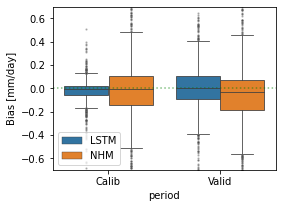

In [9]:
def boxplot_metric(metric_name, yrange=None, ylabel=None, best_value=None):
    flierprops = dict(marker='.', markerfacecolor=None, markersize=3,
                    linestyle='none', markeredgecolor='grey', alpha=.3)

    var1 = Metrics_lstm_calib[metric_name].to_frame()
    var1['model'] = 'LSTM'
    var1['period'] = 'Calib'
    
    var2 = Metrics_lstm_valid[metric_name].to_frame()
    var2['model'] = 'LSTM'
    var2['period'] = 'Valid'
    
    var3 = Metrics_NHM_calib[metric_name].to_frame()
    var3['model'] = 'NHM'
    var3['period'] = 'Calib'
   
    var4 = Metrics_NHM_valid[metric_name].to_frame()
    var4['model'] = 'NHM'
    var4['period'] = 'Valid'
    
    df = pd.concat([var1, var2, var3, var4], axis=0)

    plt.figure(figsize=(4,3))
    sns.boxplot(data=df, x='period', y=metric_name, hue='model', linewidth=.8, flierprops=flierprops)
    
    if best_value is not None:
        plt.axhline(y=best_value, ls=":", color='green', alpha=.5)
    
    if yrange:
        plt.ylim(yrange)
    
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(metric_name)
    
    
    plt.legend(loc='lower left')


boxplot_metric(metric_name='Bias [mm/day]', yrange=(-.7,.7), best_value=0)


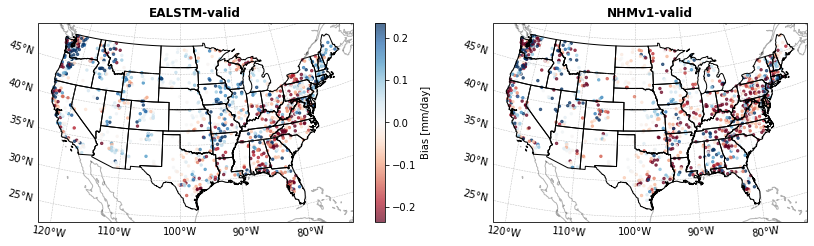

In [10]:
def mapplot_metric(metric_name, cmap='jet', crange=None):
    df_aorc = Metrics_lstm_valid[['dec_long_va','dec_lat_va',metric_name]]
    df_c404 = Metrics_NHM_valid[['dec_long_va','dec_lat_va',metric_name]]

    var = df_aorc[metric_name]
    if not crange:
        cmax = np.max([np.abs(var.quantile(.1)), np.abs(var.quantile(.9))])
        cmin = -1 * cmax
        crange = (cmin, cmax)

    cbar_kwargs=dict(orientation='horizontal', pad=0.1, aspect=30, shrink=0.6)
    fig = plt.figure(figsize=(16,12))
    gs1 = gridspec.GridSpec(1, 2)
    gs1.update(wspace=-0.05015, hspace=.25) # set the spacing between axes. 

    ax1 = plt.subplot(gs1[0],projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    s = df_aorc.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=metric_name, 
                             s=6, vmin=crange[0], vmax=crange[1], cmap=cmap, alpha=.7)
#     print(s)
#     plt.colorbar(s)
    
    gl = ax1.gridlines(draw_labels=True, linewidth=.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
    gl.right_labels = False
    gl.top_labels = False
    ax1.set_title('EALSTM-valid', fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())

    ax2 = plt.subplot(gs1[1],projection=proj)
    ax2.coastlines(edgecolor='gray', alpha=.3)
    ax2.add_feature(states)
    img = df_c404.plot.scatter(ax=ax2, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c=metric_name, 
                         s=6, vmin=crange[0], vmax=crange[1], cmap=cmap, alpha=.7, colorbar=False)
    gl = ax2.gridlines(draw_labels=True, linewidth=.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
    gl.right_labels = False
    gl.top_labels = False
    ax2.set_title('NHMv1-valid', fontsize = 12, fontweight='bold')
    ax2.set_extent(extent_conus, crs=ccrs.PlateCarree())
    
    fig.subplots_adjust(bottom=0.65)
    
#     plt.tight_layout()
#     cbar_ax = fig.add_axes([0.17, 0.17, 0.65, 0.04])
#     plt.colorbar(img, cax=cbar_ax, orientation="horizontal")
    

mapplot_metric(metric_name='Bias [mm/day]', cmap='RdBu')

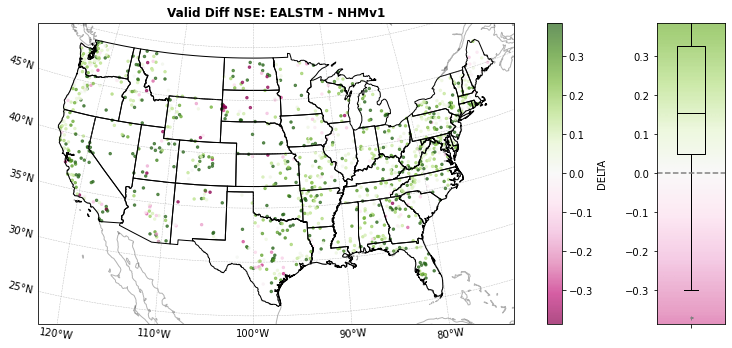

In [11]:
def mapDiffplot_metric(metric_name, delta_abs=False):
    df_aorc = Metrics_lstm_valid[['dec_long_va','dec_lat_va',metric_name]]
    df_c404 = Metrics_NHM_valid[['dec_long_va','dec_lat_va',metric_name]]

    #####
    delta = df_c404.drop(metric_name, 1)
    if delta_abs: #Positive delta always means aorc is better
        delta['DELTA'] = np.abs(df_c404[metric_name]) - np.abs(df_aorc[metric_name])
        delta_title = "Valid Diff "+metric_name+": |NHMv1| - |EALSTM|"
    else:
        delta['DELTA'] = df_aorc[metric_name] - df_c404[metric_name]
        delta_title = "Valid Diff "+metric_name+": EALSTM - NHMv1"

    var = delta['DELTA']
    cmax = np.max([np.abs(var.quantile(.2)), np.abs(var.quantile(.8))])
    cmin = -1 * cmax
    crange = (cmin, cmax)
    ymax = np.max([np.abs(var.quantile(.1)), np.abs(var.quantile(.9))])
    ymin = -1 * ymax
    yrange = (ymin, ymax)

    cbar_kwargs=dict(orientation='horizontal', pad=0.1, aspect=30, shrink=0.6)
    flierprops = dict(marker='+', markerfacecolor=None, markersize=3,
                linestyle='none', markeredgecolor='grey')

    fig = plt.figure(figsize=(13,11))
    gs = gridspec.GridSpec(9, 9)
    # gs = gs.update(wspace=0.05, hspace=.005) # set the spacing between axes. 

    ax1 = fig.add_subplot(gs[:, 0:8], projection=proj)
    # ax1 = ax[0]
    # ax1 = plt.axes(projection=proj)
    ax1.coastlines(edgecolor='gray', alpha=.3)
    ax1.add_feature(states)
    img = delta.plot.scatter(ax=ax1, x='dec_long_va', y='dec_lat_va', transform=ccrs.PlateCarree(), c='DELTA', 
                         s=6, vmin=crange[0], vmax=crange[1], cmap="PiYG", alpha=.7)
    gl = ax1.gridlines(draw_labels=True, linewidth=.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
    gl.right_labels = False
    gl.top_labels = False
    ax1.set_title(delta_title, fontsize = 12, fontweight='bold')
    ax1.set_extent(extent_conus, crs=ccrs.PlateCarree())
    
    ax2 = fig.add_subplot(gs[:, 8])
    X = [[.6, .6], [.7, .7]]
    ax2.imshow(X, interpolation='bicubic', cmap=plt.cm.PiYG_r,
              extent=(0, 2, ymin, ymax), alpha=.7)
    
    plt.boxplot(var[var.notna()], widths=.8, flierprops=flierprops, medianprops=dict(color='k'), labels=[''])
    plt.ylim(crange)
    ax2.axhline(y=0, color='gray', linestyle='--')
    ax2.set_aspect('auto')
    # if ylabel:
    #     plt.ylabel(ylabel)
    # else:
    #     plt.ylabel(metric_name)
   
    fig.subplots_adjust(bottom=0.5)
    
mapDiffplot_metric(metric_name='NSE', delta_abs=False)

/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


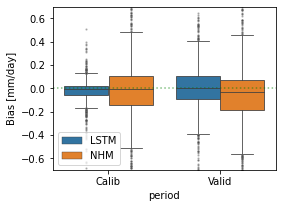

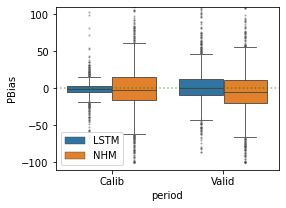

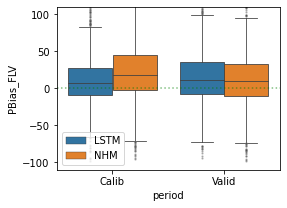

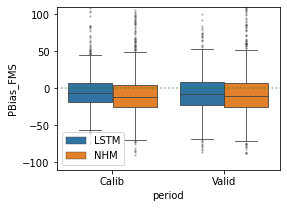

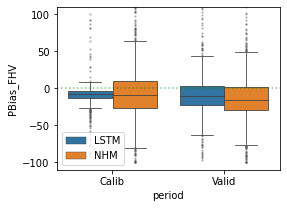

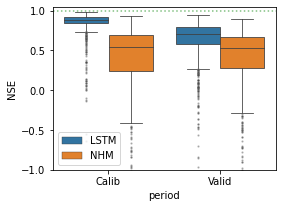

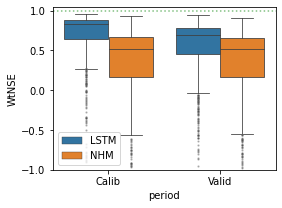

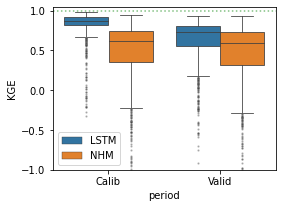

In [12]:
boxplot_metric('Bias [mm/day]', yrange=(-.7,.7), best_value=0)
boxplot_metric('PBias', yrange=(-110,110), best_value=0)
boxplot_metric(metric_name='PBias_FLV', yrange=(-110,110), best_value=0)
boxplot_metric(metric_name='PBias_FMS', yrange=(-110,110), best_value=0)
boxplot_metric(metric_name='PBias_FHV', yrange=(-110,110), best_value=0)
boxplot_metric('NSE', yrange=(-1,1.05), best_value=1)
boxplot_metric('WtNSE', yrange=(-1,1.05), best_value=1)
boxplot_metric('KGE', yrange=(-1,1.05), best_value=1)

/glade/work/mazrooei/miniconda3/envs/myxr/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


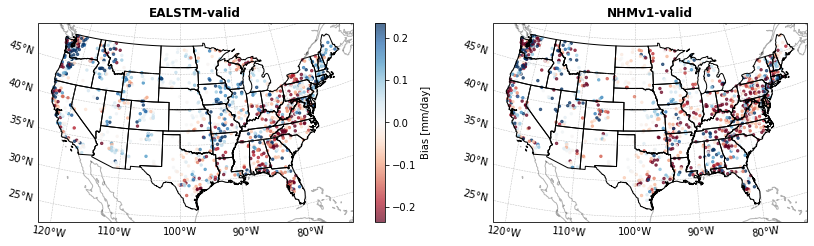

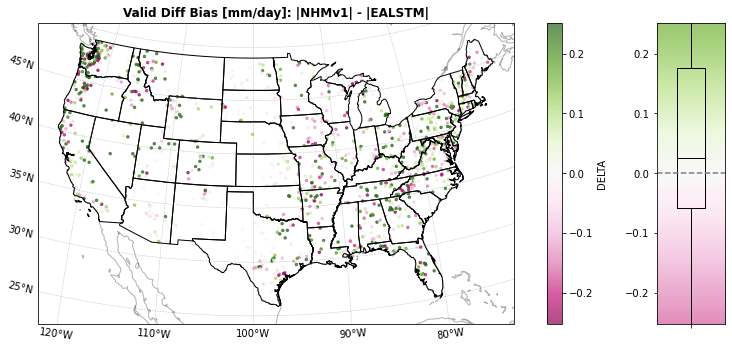

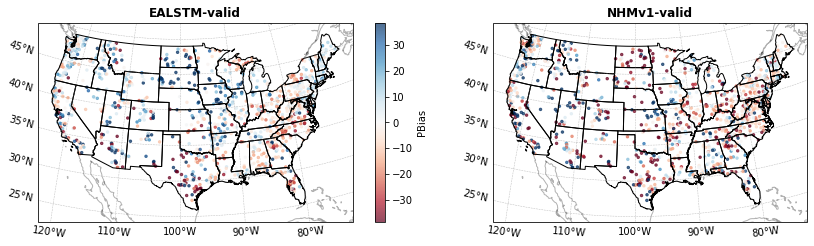

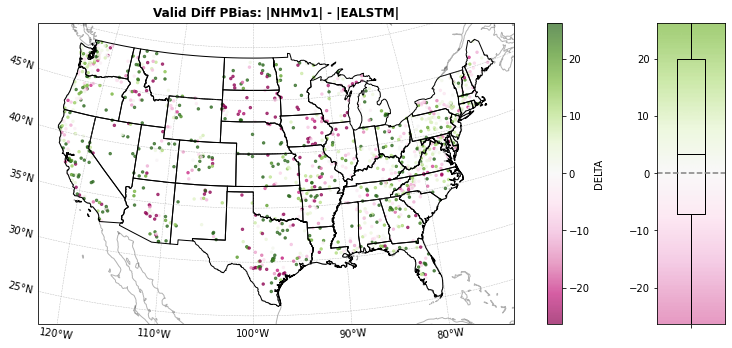

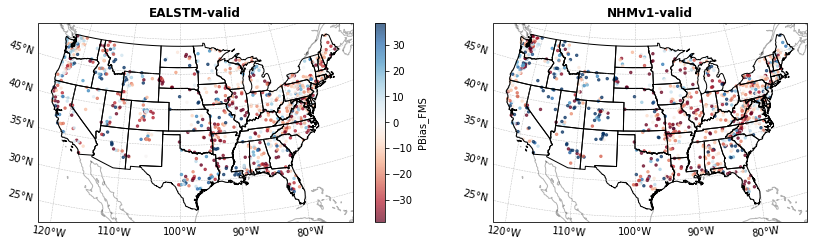

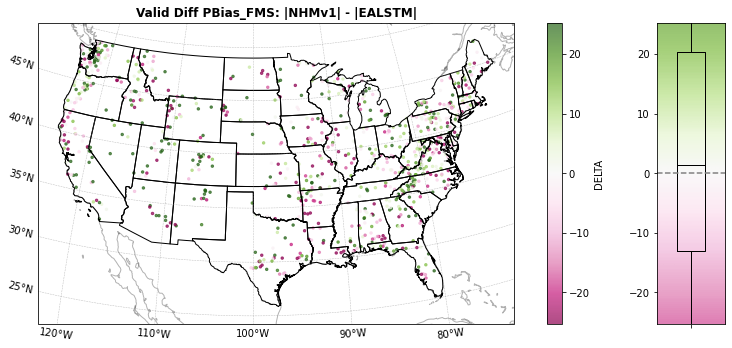

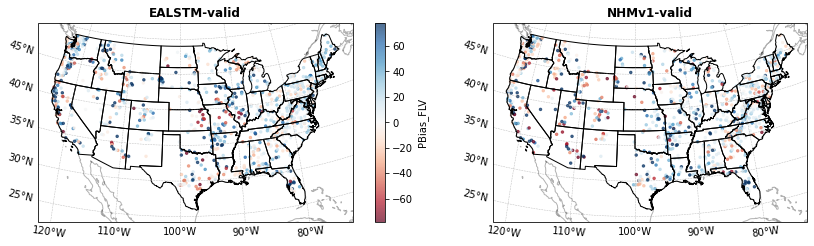

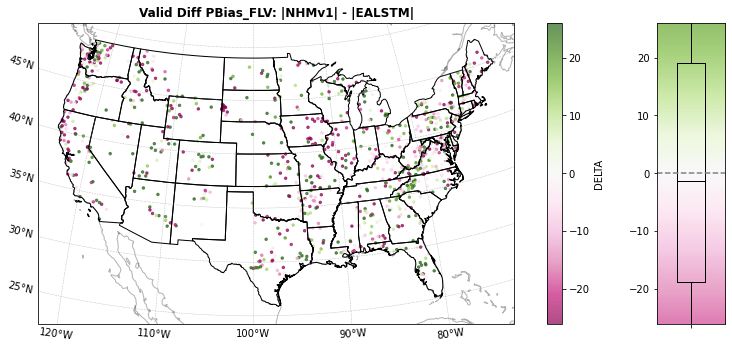

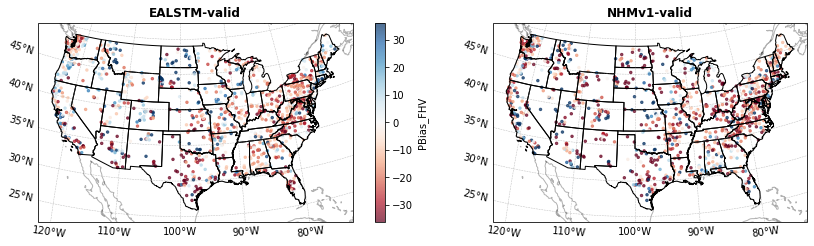

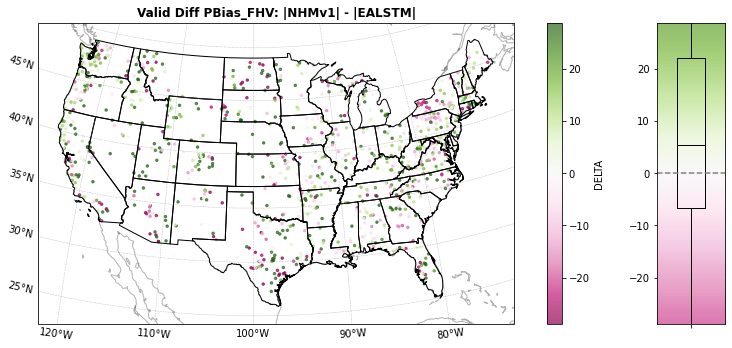

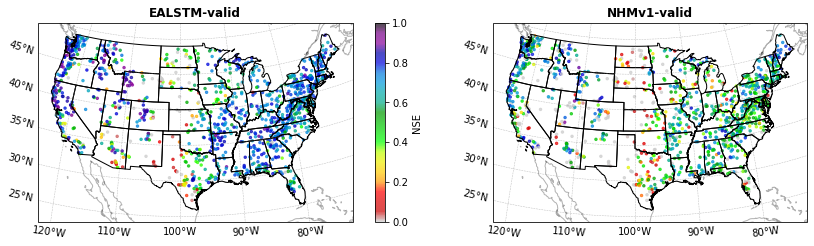

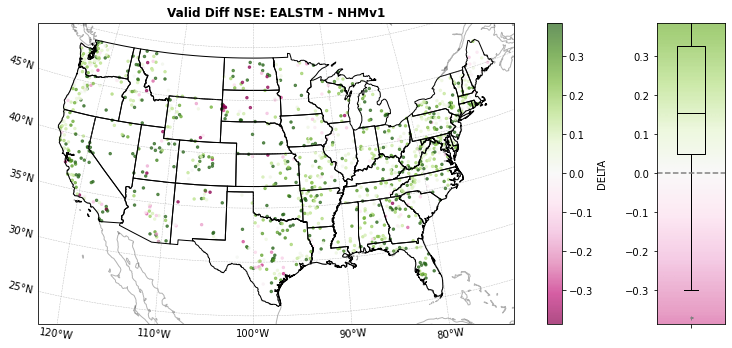

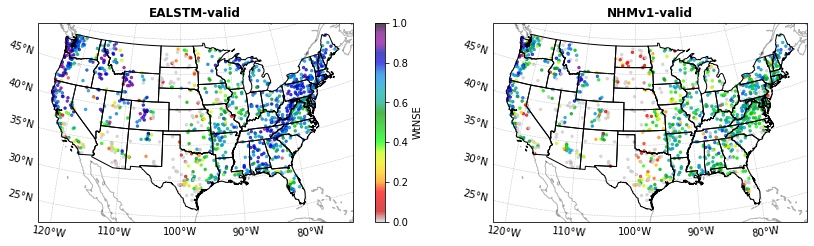

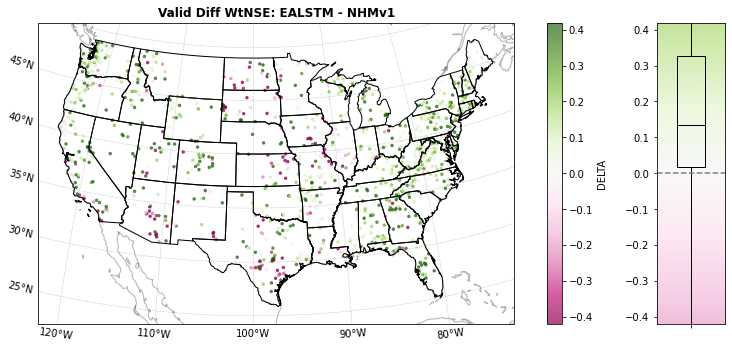

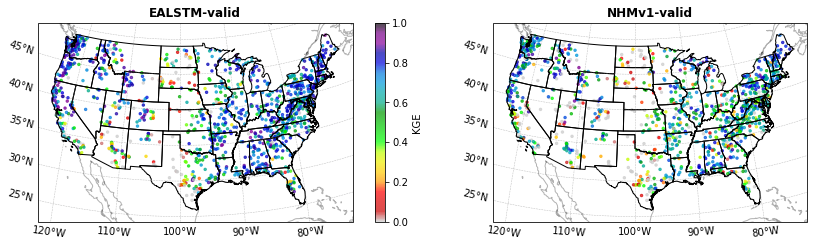

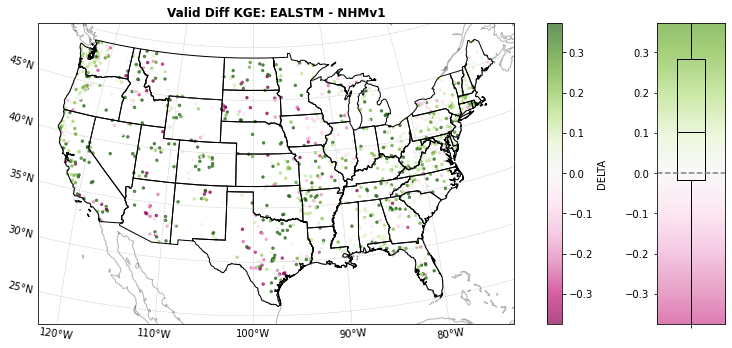

In [65]:
mapplot_metric(metric_name='Bias [mm/day]', cmap='RdBu')
mapDiffplot_metric(metric_name='Bias [mm/day]', delta_abs=True)
mapplot_metric(metric_name='PBias', cmap='RdBu')
mapDiffplot_metric(metric_name='PBias', delta_abs=True)
mapplot_metric(metric_name='PBias_FMS', cmap='RdBu')
mapDiffplot_metric(metric_name='PBias_FMS', delta_abs=True)
mapplot_metric(metric_name='PBias_FLV', cmap='RdBu')
mapDiffplot_metric(metric_name='PBias_FLV', delta_abs=True)
mapplot_metric(metric_name='PBias_FHV', cmap='RdBu')
mapDiffplot_metric(metric_name='PBias_FHV', delta_abs=True)

mapplot_metric(metric_name='NSE', cmap='nipy_spectral_r', crange=(0,1))
mapDiffplot_metric(metric_name='NSE', delta_abs=False)
mapplot_metric(metric_name='WtNSE', cmap='nipy_spectral_r', crange=(0,1))
mapDiffplot_metric(metric_name='WtNSE', delta_abs=False)
mapplot_metric(metric_name='KGE', cmap='nipy_spectral_r', crange=(0,1))
mapDiffplot_metric(metric_name='KGE', delta_abs=False)

### Hydrograph, single basin

In [169]:
Metrics_aorc.NSE.idxmax()

'13336500'

In [32]:
(Metrics_lstm_valid.NSE - Metrics_NHM_valid.NSE).nsmallest(10)

site_no
06470800   -13.8299
06360500   -10.2319
02390000    -5.2082
06853800    -3.8054
06431500    -3.3961
06347500    -3.2913
12374250    -3.1712
06430850    -1.7681
10023000    -1.5862
06392900    -1.2417
Name: NSE, dtype: float64

In [25]:
# diff = Metrics_aorc.NSE - Metrics_c404.NSE
# diff[Metrics_c404.NSE>0].nlargest(20) 
print('\n Metrics_lstm_valid.NSE.nlargest(10)')
print(Metrics_lstm_valid.NSE.nlargest(10)) 

print('\n Metrics_lstm_valid.NSE.nsmallest(10)')
print(Metrics_lstm_valid.NSE.nsmallest(10)) 

print('\n Metrics_NHM_valid.NSE.nlargest(10)')
print(Metrics_NHM_valid.NSE.nlargest(10))

print('\n Metrics_NHM_valid.NSE.nsmallest(10)')
print(Metrics_NHM_valid.NSE.nsmallest(10)) 


 Metrics_lstm_valid.NSE.nlargest(10)
site_no
13336500    0.9460
11264500    0.9388
01613525    0.9330
12013500    0.9280
12358500    0.9272
13337000    0.9254
11458000    0.9236
14299800    0.9235
12359800    0.9212
09112500    0.9189
Name: NSE, dtype: float64

 Metrics_lstm_valid.NSE.nsmallest(10)
site_no
01387450        -inf
02366000        -inf
10257600   -162.0589
06846500    -31.0004
09404208    -26.6369
06470800    -13.9047
06360500    -10.3159
06430850     -7.2401
02390000     -6.9598
10172860     -6.3227
Name: NSE, dtype: float64

 Metrics_NHM_valid.NSE.nlargest(10)
site_no
10128500    0.8967
10173450    0.8952
14301000    0.8898
06623800    0.8885
06043500    0.8845
01130000    0.8708
12354000    0.8561
01052500    0.8553
14301500    0.8515
10291500    0.8503
Name: NSE, dtype: float64

 Metrics_NHM_valid.NSE.nsmallest(10)
site_no
01387450          -inf
02366000          -inf
06846500   -33268.4773
14113200    -5722.2214
10166430     -847.7019
13083000     -460.4625
06775500  

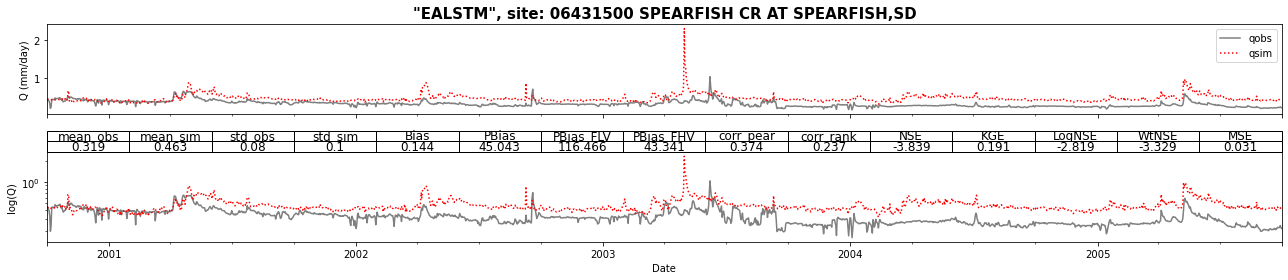

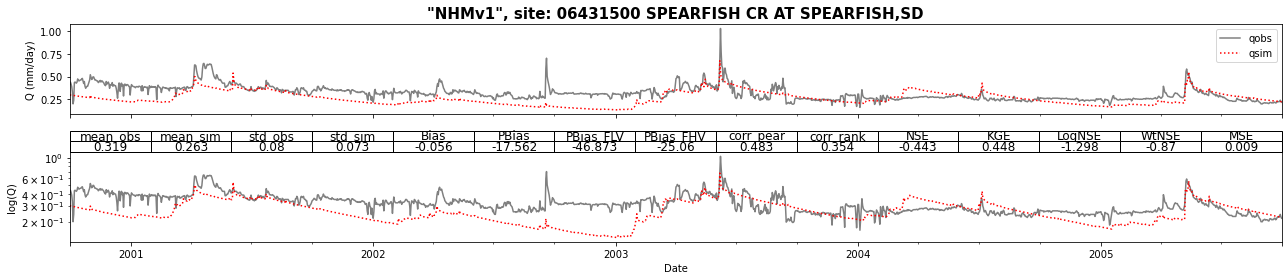

In [34]:
s = '06431500'

## First plot: AORC
df = LSTM_valid[s]
verif = my_verif(df.qobs, df.qsim).iloc[:, :15]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,4))
df.plot.line(ax=axes[0], use_index=True, sharex=True,  y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=False).legend(loc='upper right')
df.plot.line(ax=axes[1], y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=True, legend=False)
axes[0].set_ylabel('Q (mm/day)')
axes[1].set_ylabel('log(Q)')
axes[1].set_xlabel('Date')
axes[0].set_title('"EALSTM", site: '+s+' '+usgs_short.station_nm.loc[s], fontsize=15, fontweight='bold')
# axes[3].axis('off')

tbl = axes[1].table(cellText=verif.values.round(3), colLabels=list(verif.columns), loc='top', cellLoc='center' ) #pd.plotting.table(ax=axes[3], data=verif.iloc[:, :10], fontsize=47)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.tight_layout()

## Second plot: C404
df = NHM_valid[s]
verif = my_verif(df.qobs, df.qsim).iloc[:, :15]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,4))
df.plot.line(ax=axes[0], use_index=True, sharex=True,  y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=False).legend(loc='upper right')
df.plot.line(ax=axes[1], y=['qobs','qsim'], color={"qobs":"gray", 'qsim':'red'}, style=['-',':'], logy=True, legend=False)
axes[0].set_ylabel('Q (mm/day)')
axes[1].set_ylabel('log(Q)')
axes[1].set_xlabel('Date')
axes[0].set_title('"NHMv1", site: '+s+' '+usgs_short.station_nm.loc[s], fontsize=15, fontweight='bold')
# axes[3].axis('off')

tbl = axes[1].table(cellText=verif.values.round(3), colLabels=list(verif.columns), loc='top', cellLoc='center' ) #pd.plotting.table(ax=axes[3], data=verif.iloc[:, :10], fontsize=47)
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.tight_layout()

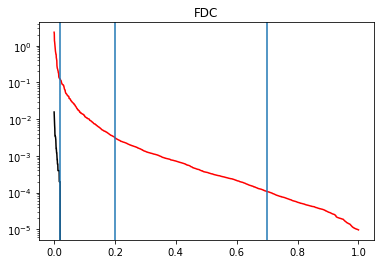

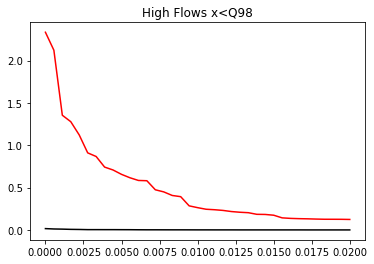

/glade/scratch/mazrooei/ipykernel_24695/2376765591.py:40: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.linspace(m1,m2,num=n_MS), np.log(obs_MS), color='black')


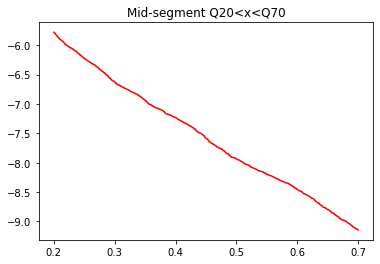

diff_MS_sim= -5.7808672068044 -9.143661468164623 3.3627942613602233
diff_MS_obs= -inf -inf nan
nan


/glade/scratch/mazrooei/ipykernel_24695/2376765591.py:49: RuntimeWarning: divide by zero encountered in log
  PBias_FMS = 100*(((np.log(QSm1)-np.log(QSm2))-(np.log(QOm1)-np.log(QOm2)))/(np.log(QOm1)-np.log(QOm2)))
/glade/scratch/mazrooei/ipykernel_24695/2376765591.py:49: RuntimeWarning: invalid value encountered in double_scalars
  PBias_FMS = 100*(((np.log(QSm1)-np.log(QSm2))-(np.log(QOm1)-np.log(QOm2)))/(np.log(QOm1)-np.log(QOm2)))
/glade/scratch/mazrooei/ipykernel_24695/2376765591.py:51: RuntimeWarning: divide by zero encountered in log
  diff_MS_obs = np.log(QOm1)-np.log(QOm2)
/glade/scratch/mazrooei/ipykernel_24695/2376765591.py:51: RuntimeWarning: invalid value encountered in double_scalars
  diff_MS_obs = np.log(QOm1)-np.log(QOm2)
/glade/scratch/mazrooei/ipykernel_24695/2376765591.py:53: RuntimeWarning: divide by zero encountered in log
  print('diff_MS_obs=', np.log(QOm1), np.log(QOm2), diff_MS_obs)
/glade/scratch/mazrooei/ipykernel_24695/2376765591.py:61: RuntimeWarning: divid

Text(0.5, 1.0, 'Low flow segment < Q30')

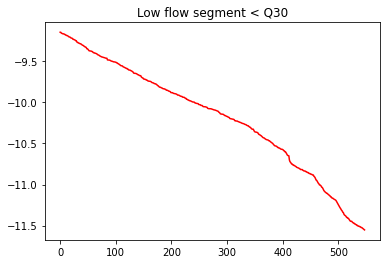

In [24]:
## FDC Plots

df = NHM_valid[s]
sim = df.qsim
obs = df.qobs
n  = len(obs)

# plt.figure(figsize=(13,3))
plt.plot(np.linspace(0,1,num=n), sorted(sim, reverse=True), color='red')
plt.plot(np.linspace(0,1,num=n), sorted(obs, reverse=True), color='black')
plt.yscale('log')
plt.title('FDC')
plt.axvline(x=.02)
plt.axvline(x=.2)
plt.axvline(x=.7)
plt.show()

## High Flows
qH = 0.02 # high flow quantile
sim_FH = sorted(sim, reverse=True)[:round(n*qH)]
obs_FH = sorted(obs, reverse=True)[:round(n*qH)]
#FDC high volume bias, top %2 flows
n_FH = len(obs_FH)
plt.plot(np.linspace(0,qH,num=n_FH), sim_FH, color='red')
plt.plot(np.linspace(0,qH,num=n_FH), obs_FH, color='black')
plt.title('High Flows x<Q98')
# plt.yscale('log')
plt.show()

PBias_FHV = 100*np.sum(np.subtract(sim_FH,obs_FH))/np.sum(obs_FH) 


## Mid Segment
m1 = .2
m2 = .7
sim_MS = sorted(sim, reverse=True)[round(n*m1):round(n*m2)] #np.add(sorted(obs, reverse=True)[round(n*m1):round(n*m2)], 0.5) 
obs_MS = sorted(obs, reverse=True)[round(n*m1):round(n*m2)]
n_MS = len(obs_MS)
plt.plot(np.linspace(m1,m2,num=n_MS), np.log(sim_MS), color='red')
plt.plot(np.linspace(m1,m2,num=n_MS), np.log(obs_MS), color='black')
plt.title('Mid-segment Q20<x<Q70')
plt.show()

QOm1 = obs_MS[0]
QSm1 = sim_MS[0]
QOm2 = obs_MS[-1]
QSm2 = sim_MS[-1]
#FDC midsegment slope bias
PBias_FMS = 100*(((np.log(QSm1)-np.log(QSm2))-(np.log(QOm1)-np.log(QOm2)))/(np.log(QOm1)-np.log(QOm2))) 
diff_MS_sim = np.log(QSm1)-np.log(QSm2)
diff_MS_obs = np.log(QOm1)-np.log(QOm2)
print('diff_MS_sim=', np.log(QSm1), np.log(QSm2), diff_MS_sim)
print('diff_MS_obs=', np.log(QOm1), np.log(QOm2), diff_MS_obs)
print(PBias_FMS)

## Low Flows
qL = 0.7 # Low flow quantile
sim_FL = sorted(sim, reverse=True)[round(n*qL):]
obs_FL = sorted(obs, reverse=True)[round(n*qL):]
plt.plot(np.log(sim_FL), color='red')
plt.plot(np.log(obs_FL), color='black')
plt.title('Low flow segment < Q30')


In [22]:
np.log(np.mean(sim_FL)*0.0001)

-11.084871989735307